# Text Generation using RNNs with TensorFlow

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
path_to_file = 'bible.txt'

text = open(path_to_file, 'rb').read().decode(encoding = 'utf-8') 

text = text[:len(text)//10]

In [4]:
vocab = sorted(set(text))
vocab_dict_encode = dict((j,i) for i,j in enumerate(vocab))
vocab_dict_decode = dict((i,j) for i,j in enumerate(vocab))

In [5]:
print(text[:500])

1:1 In the beginning God created the heaven and the earth.

1:2 And the earth was without form, and void; and darkness was upon
the face of the deep. And the Spirit of God moved upon the face of the
waters.

1:3 And God said, Let there be light: and there was light.

1:4 And God saw the light, that it was good: and God divided the light
from the darkness.

1:5 And God called the light Day, and the darkness he called Night.
And the evening and the morning were the first day.

1:6 An


In [6]:
n_chars = len(text)
n_vocab = len(vocab)
print('Total Characters: ', n_chars)
print('Total Vocab: ', n_vocab)

Total Characters:  443226
Total Vocab:  73


In [7]:
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([vocab_dict_encode[char] for char in seq_in])
    dataY.append(vocab_dict_encode[seq_out])
n_patterns = len(dataX)
print('Total Patterns: ', n_patterns)

Total Patterns:  443126


In [8]:
X = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X = X / float(n_vocab)
y = torch.tensor(dataY)
print(X.shape, y.shape)

torch.Size([443126, 100, 1]) torch.Size([443126])


In [9]:
def split_tensors(X, Y, train_ratio=0.9):
    assert X.size(0) == Y.size(0), 'X and Y must have the same number of samples'

    num_samples = X.size(0)
    split_index = int(num_samples * train_ratio)

    shuffled_indices = torch.randperm(num_samples)

    X_shuffled = X[shuffled_indices]
    Y_shuffled = Y[shuffled_indices]

    X_train = X_shuffled[:split_index]
    X_val = X_shuffled[split_index:]
    Y_train = Y_shuffled[:split_index]
    Y_val = Y_shuffled[split_index:]

    return X_train, X_val, Y_train, Y_val

In [10]:
X_train, X_val, Y_train, Y_val = split_tensors(X, y)

In [11]:
class CharModel(nn.Module):
    def __init__(self):
        super(CharModel,self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [12]:
EPOCHS = 40
BATCH_SIZE = 128
model = CharModel()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(reduction='sum')

train_loader = DataLoader(TensorDataset(X_train, Y_train), shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(TensorDataset(X_val, Y_val), shuffle=True, batch_size=BATCH_SIZE)

In [13]:
t_acc = []
t_los = []

v_acc = []
v_los = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    running_loss_v = 0.0
    correct_v = 0
    total_v = 0
    
    for (inputs, labels) in train_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    with torch.no_grad():
        for (inputs, labels) in val_loader:
            # Move data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                        
            # Update running loss
            running_loss_v += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_v += labels.size(0)
            correct_v += (predicted == labels).sum().item()

    t_acc.append((correct/total)*100)
    t_los.append(running_loss/len(train_loader))

    v_acc.append((correct_v/total_v)*100)
    v_los.append(running_loss_v/len(val_loader))

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {(correct/total)*100:.2f}%, Val Loss: {running_loss_v/len(val_loader):.4f}, Val Accuracy: {(correct_v/total_v)*100:.2f}%')

Epoch 1/40, Train Loss: 325.0903, Train Accuracy: 30.51%, Val Loss: 289.8568, Val Accuracy: 35.87%
Epoch 2/40, Train Loss: 273.3431, Train Accuracy: 39.43%, Val Loss: 260.0857, Val Accuracy: 42.27%
Epoch 3/40, Train Loss: 249.9004, Train Accuracy: 44.61%, Val Loss: 242.9535, Val Accuracy: 46.28%
Epoch 4/40, Train Loss: 235.1696, Train Accuracy: 47.88%, Val Loss: 234.6631, Val Accuracy: 48.18%
Epoch 5/40, Train Loss: 224.1144, Train Accuracy: 50.17%, Val Loss: 222.6519, Val Accuracy: 50.55%
Epoch 6/40, Train Loss: 215.0617, Train Accuracy: 52.07%, Val Loss: 213.9350, Val Accuracy: 52.87%
Epoch 7/40, Train Loss: 207.9734, Train Accuracy: 53.56%, Val Loss: 209.8333, Val Accuracy: 53.54%
Epoch 8/40, Train Loss: 202.2193, Train Accuracy: 54.76%, Val Loss: 208.6357, Val Accuracy: 53.98%
Epoch 9/40, Train Loss: 197.1195, Train Accuracy: 55.81%, Val Loss: 200.5409, Val Accuracy: 55.50%
Epoch 10/40, Train Loss: 192.9760, Train Accuracy: 56.69%, Val Loss: 200.3596, Val Accuracy: 55.46%
Epoch 11/

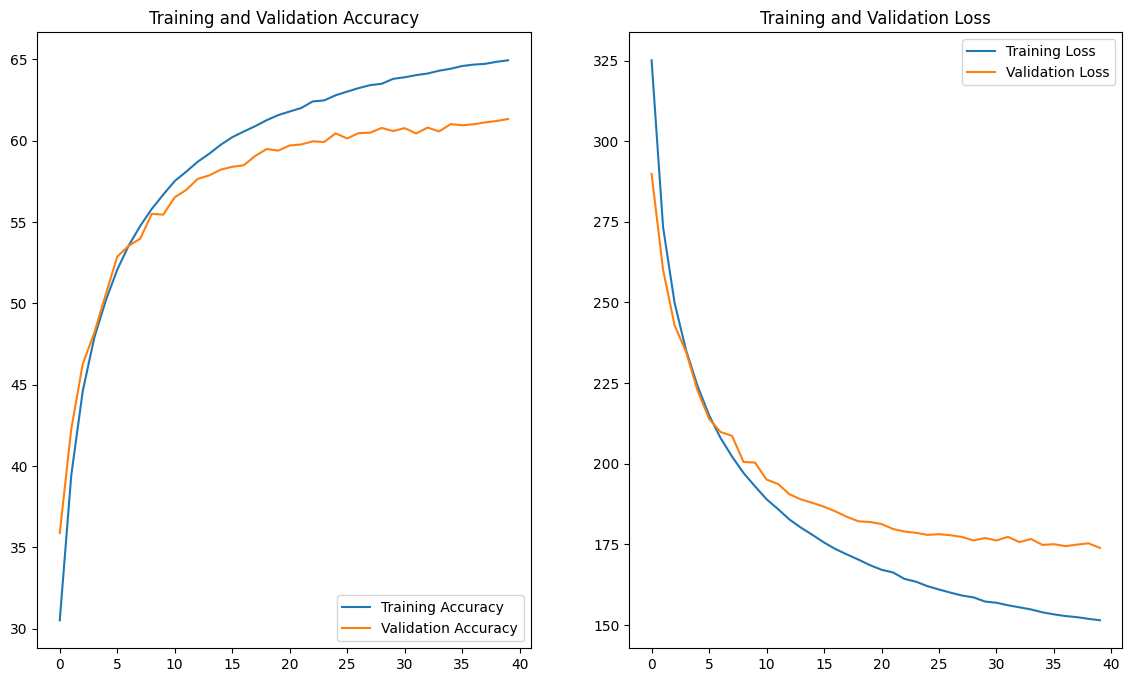

In [16]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, t_acc, label='Training Accuracy')
plt.plot(epochs_range, v_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, t_los, label='Training Loss')
plt.plot(epochs_range, v_los, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
torch.save([model.state_dict(), vocab_dict_encode], 'model.pth')

Here the model is ready and saved, so now it can be loaded!

In [16]:
best_model, vocab_dict_encode = torch.load('model.pth')

In [17]:
class CharModel(nn.Module):
    def __init__(self):
        super(CharModel,self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x
model = CharModel()
model.load_state_dict(best_model)

TypeError: Expected state_dict to be dict-like, got <class '__main__.CharModel'>.